# Analyzing Word Pairs With Temporal Drift
By: Adam Li

Now that I've analyzed word pairs between various groups of word pairs (e.g. different, reverse, probe overlap, target overlap and same group), it seems that I need to:
1. reduce the dimensionality of my frequency, time and channel domain
2. manage the temporal drift effect of my data across experimental blocks

In [1]:
# Import Necessary Libraries
import numpy as np
import scipy.io

import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
import scipy.stats as stats
from scipy.spatial import distance as Distance

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

In [2]:
######## Load in EVENTS struct to find correct events
eventsDir = '../NIH034/behavioral/paRemap/' + 'events.mat'

events = scipy.io.loadmat(eventsDir)
events = events['events']

# print number of incorrect events and which words they belonged to
incorrectIndices = events['isCorrect'] == 0
incorrectEvents = events[incorrectIndices]
incorrectWords = []
wordList = {}
for i in range(0, len(incorrectEvents)):
    incorrectWords.append(incorrectEvents['probeWord'][i][0])

for word in np.unique(incorrectEvents['probeWord']):
    wordList[str(word)] = sum(incorrectWords == word)
    
print "There were ",len(incorrectEvents), " number of incorrect events."
print "The list of incorrect probe words: \n", wordList
# 
# get only correct events
correctIndices = events['isCorrect'] == 1
events = events[correctIndices]

print "\nThis is the length of the events struct with only correct responses: ", len(events)

There were  49  number of incorrect events.
The list of incorrect probe words: 
{"[u'PANTS']": 7, "[u'JUICE']": 8, "[u'BRICK']": 12, "[u'CLOCK']": 13, "[u'GLASS']": 9}

This is the length of the events struct with only correct responses:  1431


### Different Word Groups

The struct from MATLAB has

* data.powerMatZ = thisPowMat;
* data.chanNum = thisChan;
* data.chanStr = thisChanStr;
* data.probeWord = THIS_TRIGGER;
* data.targetWord = targetWord;
* data.timeZero = 45; 
* data.vocalization = data.timeZero + round([metaEvents.responseTime]/Overlap);
       
Input:
A list of directories that correspond to each session and block #. Within each directory there is a list of word pairs available from that sessionBlock and structs that represent the data from each channel. 

Either the words are completely different, reversed, probe overlap, target overlap, or completely the same

Algorithm:
0. Analyze block 0/1, 1/2, 2/3, 3/4, 4/5 (5 total)
1. Loop through each channel:
    - extract probewords, targetwords, Z scored power matrix, channel #, channel string, time zero(probe on), vocalization
2. Create Feature Vectors
    - extract delta, theta and high gamma frequencies
    - run ANOVA on each time/freq window
    - compute a threshold to include channel for feature vector
3. Plot Histogram of Distances From the Other's centroid

In [3]:
######## Get list of files (.mat) we want to work with ########
filedir = '../condensed_data/blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:]
print "Blocks are: \n", os.listdir(filedir+sessions[0])

# functions for finding the different groups of word pairings
def find_reverse(wordpair, groups):
    # split wordpair and reverse
    wordsplit = wordpair.split('_')
    wordsplit.reverse()
    reverseword = '_'.join(wordsplit)
    
    # find index of reversed word index
    try:
        reverseword_index = groups.index(reverseword)
    except:
        reverseword_index = -1
    
    return reverseword_index
def find_different(wordpair, groups):
    # split wordpair and reverse
    wordsplit = wordpair.split('_')    
    
    differentword_index = []
    
    for idx, group in enumerate(groups):
        groupsplit = group.split('_')
        
        if not any(x in groupsplit for x in wordsplit):
            differentword_index.append(idx)
    
    # convert to single number if a list
    if len(differentword_index) == 1:
        differentword_index = differentword_index[0]
    
    return differentword_index

def find_probe(wordpair, groups):
    # split wordpair and reverse
    wordsplit = wordpair.split('_')    
    probeword_index = []
    
    # loop through group of words to check word pair in
    for idx, group in enumerate(groups):
        groupsplit = group.split('_')
        
        # check if probe word overlaps
        if wordsplit[0] == groupsplit[0] and wordsplit[1] != groupsplit[1]:
            probeword_index.append(idx)
    
    # convert to single number if a list
    if len(probeword_index) != 1 and probeword_index:
        print probeword_index
        print "problem in find probe"
    elif not probeword_index: # if no probe words overlap
        probeword_index = -1
    else:
        probeword_index = probeword_index[0]
    
    return probeword_index

def find_target(wordpair, groups):
    # split wordpair and reverse
    wordsplit = wordpair.split('_')    
    targetword_index = []
    
    # loop through group of words to check word pair in
    for idx, group in enumerate(groups):
        groupsplit = group.split('_')
        
        # check if target word overlaps
        if wordsplit[1] == groupsplit[1] and wordsplit[0] != groupsplit[0]:
            targetword_index.append(idx)
    
    # convert to single number if a list
    if len(targetword_index) != 1 and targetword_index:
        print targetword_index
        print "problem in find target"
    elif not targetword_index: # if no target words overlap
        targetword_index = -1
    else:
        targetword_index = targetword_index[0]
    
    return targetword_index

def find_same(wordpair, groups):
    # split wordpair and reverse
    wordsplit = wordpair.split('_')    
    
    try:
        sameword_index = groups.index(wordpair)
    except:
        sameword_index = -1
    return sameword_index

def inGroup(group, names):
    for i in range(0, len(group)):
        if cmpT(group[i],names):
            return True
    return False

def cmpT(t1, t2): 
    return sorted(t1) == sorted(t2)

Blocks are: 
['BLOCK_0', 'BLOCK_1', 'BLOCK_2', 'BLOCK_3', 'BLOCK_4', 'BLOCK_5']


In [93]:
### Functions to help extract features and plot histogram of distances
# loops through each wordpairing group and extract features
def extractFeatures(wordgroup, session, blockone, blocktwo):
    fig = plt.figure(figsize=(7.5*len(wordgroup), 3))
    
    for idx, pair in enumerate(wordgroup):
        # load in data
        first_wordpair_dir = firstblock_dir + '/' + pair[0]
        second_wordpair_dir = secondblock_dir + '/' + pair[1]

        # initialize np arrays for holding feature vectors for each event
        first_pair_features = []
        second_pair_features = []

        # load in channels
        first_channels = os.listdir(first_wordpair_dir)
        second_channels = os.listdir(second_wordpair_dir)
        # loop through channels
        for jdx, chans in enumerate(first_channels):
            first_chan_file = first_wordpair_dir + '/' + chans
            second_chan_file = second_wordpair_dir + '/' + chans

            # load in data
            data_first = scipy.io.loadmat(first_chan_file)
            data_first = data_first['data']
            data_second = scipy.io.loadmat(second_chan_file)
            data_second = data_second['data']

            ## 06: get the time point for probeword on
            first_timeZero = data_first['timeZero'][0][0][0]
            second_timeZero = data_second['timeZero'][0][0][0]

            ## 07: get the time point of vocalization
            first_vocalization = data_first['vocalization'][0][0][0]
            second_vocalization = data_second['vocalization'][0][0][0]

            ## Power Matrix
            first_matrix = data_first['powerMatZ'][0][0]
            second_matrix = data_second['powerMatZ'][0][0]
            first_matrix = first_matrix[:, freq_bands,:]
            second_matrix = second_matrix[:, freq_bands,:]

            ### 02: get only the time point before vocalization
            first_mean = []
            second_mean = []
            for i in range(0, len(first_vocalization)):
                # either go from timezero -> vocalization, or some other timewindow
                first_mean.append(np.mean(first_matrix[i,:,first_timeZero:first_vocalization[i]], axis=1))
#                     first_mean.append(np.ndarray.flatten(first_matrix[i,:,first_vocalization[i]-num_time_windows:first_vocalization[i]]))
            for i in range(0, len(second_vocalization)):
                second_mean.append(np.mean(second_matrix[i,:,second_timeZero:second_vocalization[i]], axis=1))
#                     second_mean.append(np.ndarray.flatten(second_matrix[i,:,second_vocalization[i]-num_time_windows:second_vocalization[i]]))

            # create feature vector for each event
            if jdx == 0:
                first_pair_features.append(first_mean)
                second_pair_features.append(second_mean)
                first_pair_features = np.squeeze(np.array(first_pair_features))
                second_pair_features = np.squeeze(np.array(second_pair_features))
            else:
                first_pair_features = np.concatenate((first_pair_features, first_mean), axis=1)
                second_pair_features = np.concatenate((second_pair_features, second_mean), axis=1)
        # end of loop through channels
        
        # compute paired distances between each feature matrix
        first_hist, second_hist = computePairDistances(first_pair_features, second_pair_features)
        
        ## Plotting Paired Distances
        plt.subplot(1, len(wordgroup), idx+1)
#         plt.subplot(1, 5, )
        plt.hist(first_hist, label=pair[0],  lw=3, alpha = 0.75)
        plt.hist(second_hist, label=pair[1],  lw=3, alpha = 0.75)
        plt.ylim([0.0, 6.0])
        plt.xlim([0.0, 1.6])
        plt.legend()
        plt.title(session + ' comparing ' + pair[0] + '(' + str(len(first_pair_features)) +') vs '+ pair[1] + '(' + str(len(second_pair_features)) +')')

def computePairDistances(first_mat, second_mat):
    first_centroid = np.mean(first_mat, axis=0)
    second_centroid = np.mean(second_mat, axis=0)
    
    # compute pairwise distance to other centroid
    first_distances = np.array([distances(x, second_centroid) for x in first_mat])
    second_distances = np.array([distances(x, first_centroid) for x in second_mat])
    
#     first_distances = []
#     second_distances = []
#     for idx in range(0, first_mat.shape[0]):
#         first_distances.append([distances(x, first_mat[idx,:]) for x in second_mat])
#     for idx in range(0, second_mat.shape[0]):
#         second_distances.append([distances(x, second_mat[idx,:]) for x in first_mat])
        
#     first_distances = np.array(first_distances)
#     second_distances = np.array(second_distances)
    return first_distances, second_distances      

### Data Processing
Go through and collect lists of word_pairs that are associated with one of the groups defined: same, reverse, probe, target, different. 

Then I can go through each group listing and analyze the data correspondingly. Obviously this depends on the matlab dirs being saved in a certain manner: '/blocks/sessions/blocks/wordpairs/channels'

In [96]:
##### HYPER-PARAMETERS TO TUNE
anova_threshold = 90   # how many channels we want to keep
distances = Distance.cosine # define distance metric to use
num_time_windows = 5
freq_bands = [0, 1, 6]
# freq_bands = np.arange(0,7,1)

freq_labels = ['delta', 'theta', 'alpha', 'beta', 'low gamma', 'high gamma', 'HFO']
print freq_bands
print [freq_labels[i] for i in freq_bands]

print "The length of the feature vector for each channel will be: ", num_time_windows*len(freq_bands)

[0, 1, 6]
['delta', 'theta', 'HFO']
The length of the feature vector for each channel will be:  15


Analyzing session  session_1
Analyzing block  BLOCK_0  and  BLOCK_1
['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_JUICE', 'JUICE_GLASS']
['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_PANTS', 'PANTS_GLASS']
[['BRICK_CLOCK', 'BRICK_CLOCK'], ['CLOCK_BRICK', 'CLOCK_BRICK']]
[['BRICK_CLOCK', 'CLOCK_BRICK']]
[['GLASS_JUICE', 'GLASS_PANTS']]
[['JUICE_GLASS', 'PANTS_GLASS']]
[['BRICK_CLOCK', 'GLASS_PANTS'], ['BRICK_CLOCK', 'PANTS_GLASS']]
Analyzing block  BLOCK_1  and  BLOCK_2
['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_PANTS', 'PANTS_GLASS']
['BRICK_JUICE', 'GLASS_PANTS', 'JUICE_BRICK', 'PANTS_GLASS']
[['GLASS_PANTS', 'GLASS_PANTS'], ['PANTS_GLASS', 'PANTS_GLASS']]
[['GLASS_PANTS', 'PANTS_GLASS']]
[['BRICK_CLOCK', 'BRICK_JUICE']]
[['CLOCK_BRICK', 'JUICE_BRICK']]
[['BRICK_CLOCK', 'GLASS_PANTS'], ['BRICK_CLOCK', 'PANTS_GLASS']]
Analyzing block  BLOCK_2  and  BLOCK_3
['BRICK_JUICE', 'GLASS_PANTS', 'JUICE_BRICK', 'PANTS_GLASS']
['BRICK_JUICE', 'CLOCK_GLASS', 'GLASS_CLOCK', 'JUICE_BRICK']
[['BRICK_JUICE', 'BRICK_JUICE'

/Users/adam2392/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/adam2392/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:51: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


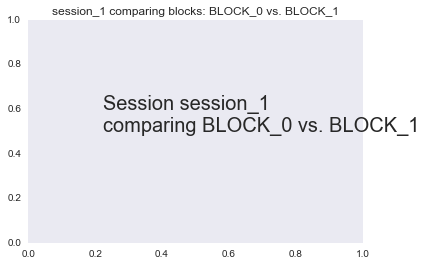

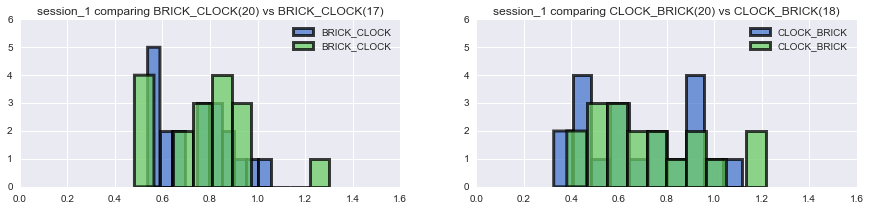

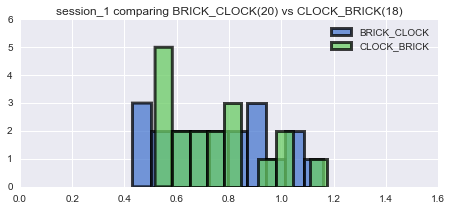

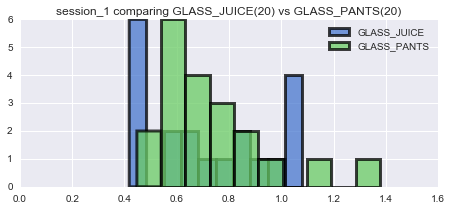

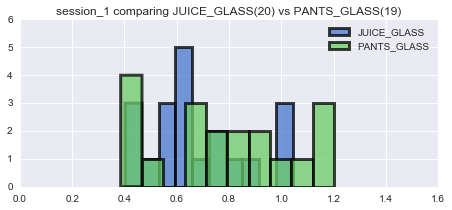

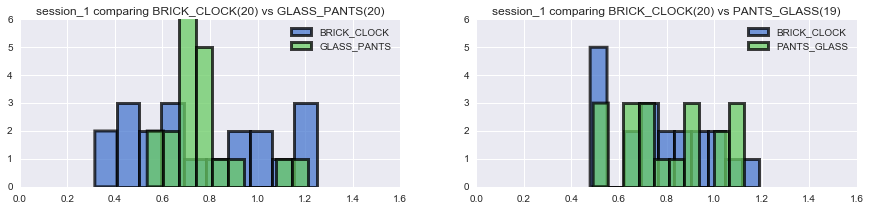

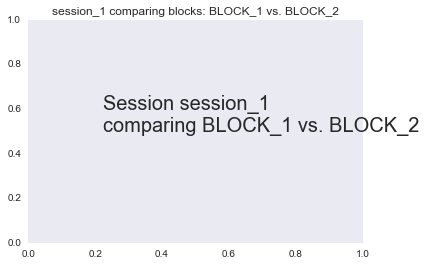

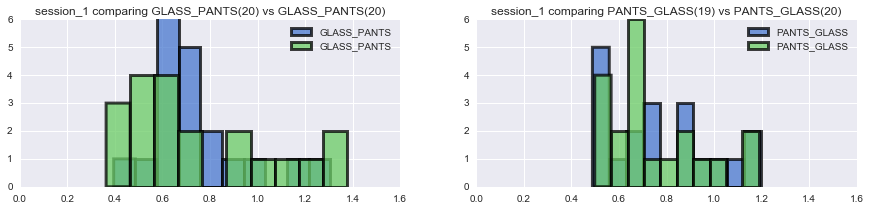

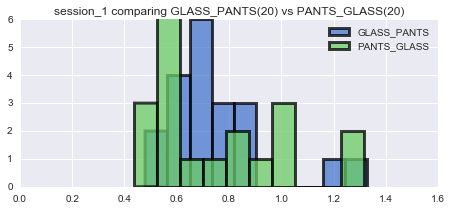

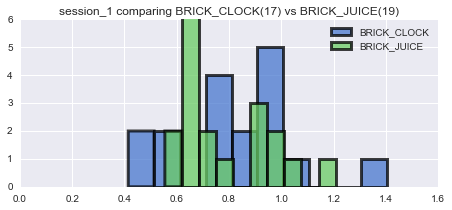

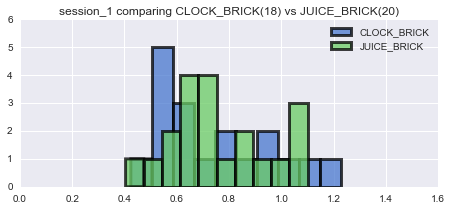

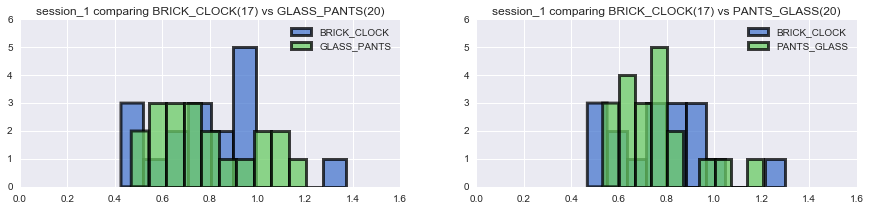

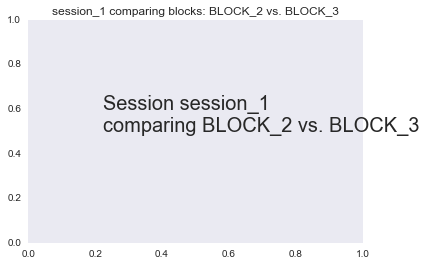

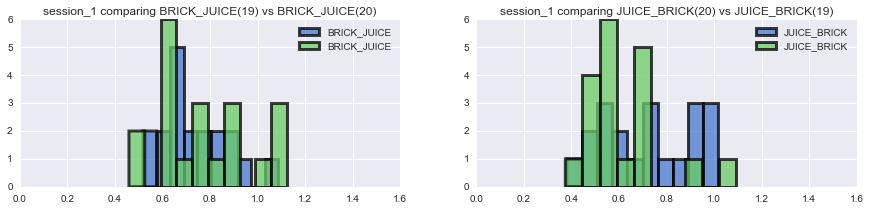

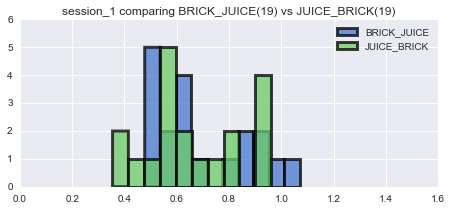

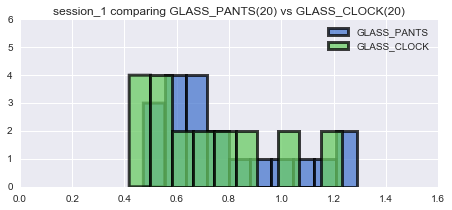

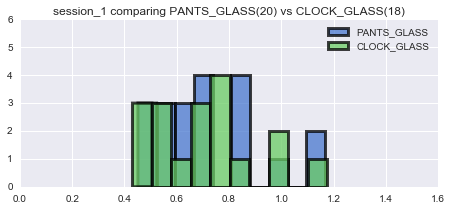

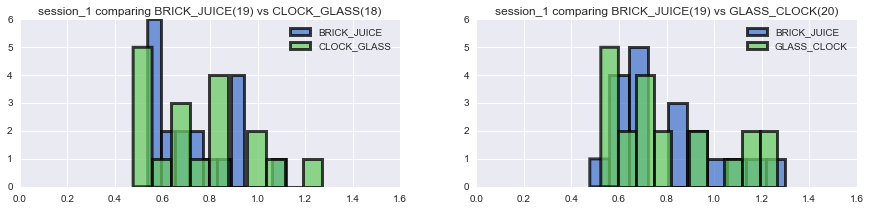

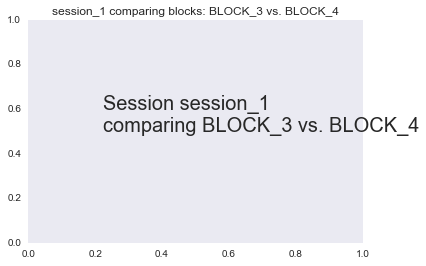

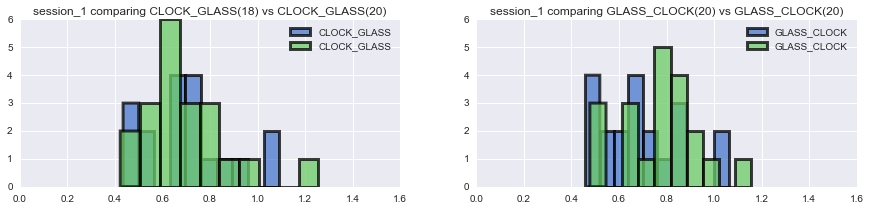

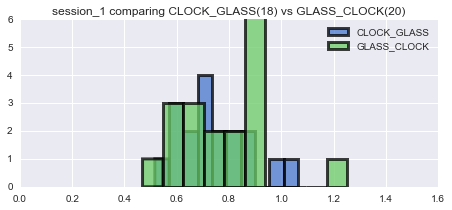

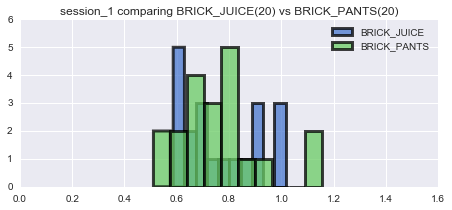

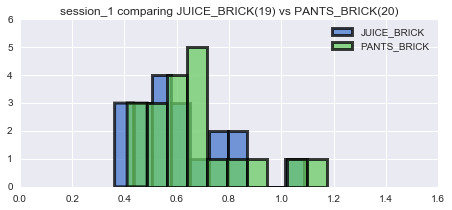

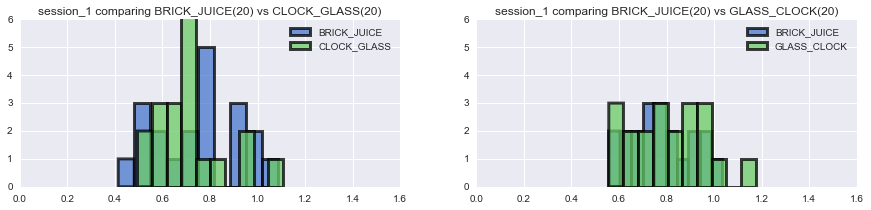

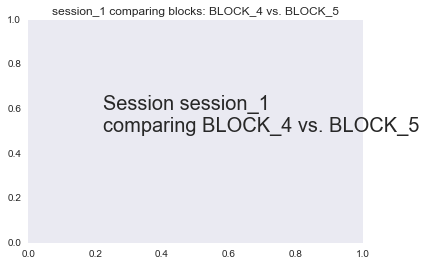

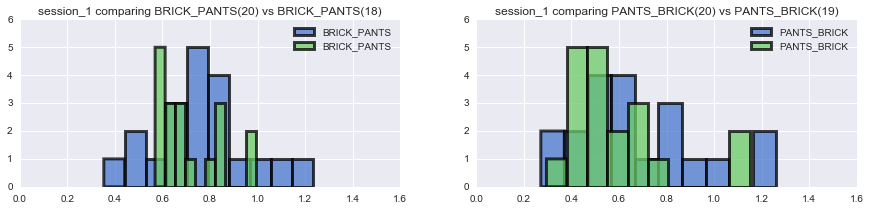

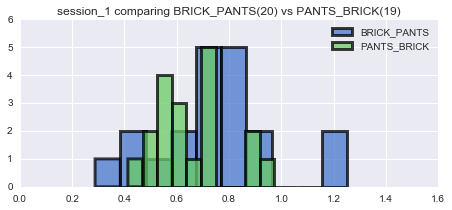

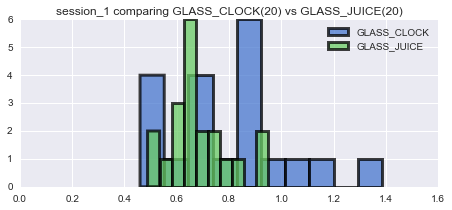

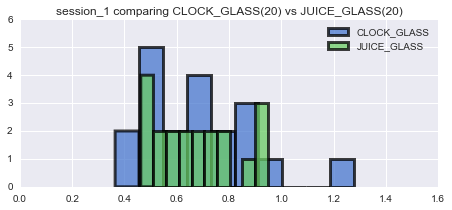

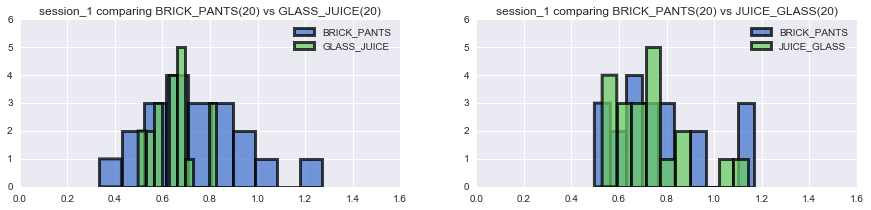

In [97]:
######## Get list of files (.mat) we want to work with ########
filedir = '../condensed_data/blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:]

# loop through each session
for session in sessions:
    print "Analyzing session ", session
    sessiondir = filedir + session
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)
    
    if len(blocks) != 6: # error check on the directories
        print blocks
        print("Error in the # of blocks. There should be 5.")
        break
    
    # loop through each block one at a time, analyze
    for i in range(0, 5):
        print "Analyzing block ", blocks[i], ' and ', blocks[i+1]
        firstblock = blocks[i]
        secondblock = blocks[i+1]
        
        firstblock_dir = sessiondir+'/'+firstblock
        secondblock_dir = sessiondir+'/'+secondblock
        # in each block, get list of word pairs from first and second block
        first_wordpairs = os.listdir(sessiondir+'/'+firstblock)
        second_wordpairs = os.listdir(sessiondir+'/'+secondblock)
        
        diff_word_group = []
        reverse_word_group = []
        probe_word_group = []
        target_word_group = []
        same_word_group = []
        
        print first_wordpairs
        print second_wordpairs
        
        #### plot meta information about which session and blocks we're analyzing
        fig=plt.figure()
        axes = plt.gca()
        ymin, ymax = axes.get_ylim()
        xmin, xmax = axes.get_xlim()
        plt.text((xmax-xmin)/4.5, (ymax-ymin)/2, r'Session %s %scomparing %s vs. %s'%(session, '\n',firstblock, secondblock), fontsize=20)
        plt.title(session + ' comparing blocks: ' + firstblock + ' vs. ' + secondblock)
        plt.grid(False)
        
        # go through first block and assign pairs to different groups
        for idx, pair in enumerate(first_wordpairs):
#             print "Analyzing ", pair
            # obtain indices of: sameword, reverseword, differentwords, probeoverlap, targetoverlap
            same_word_index = find_same(pair, second_wordpairs)
            reverse_word_index = find_reverse(pair, second_wordpairs)
            diff_word_index = find_different(pair, second_wordpairs)
            probe_word_index = find_probe(pair, second_wordpairs)
            target_word_index = find_target(pair, second_wordpairs)
            
            # append to list groupings holding pairs of these word groupings
            if same_word_index != -1 and not inGroup(same_word_group, [pair, second_wordpairs[same_word_index]]):
                same_word_group.append([pair, second_wordpairs[same_word_index]])
            if reverse_word_index != -1 and not inGroup(reverse_word_group, [pair, second_wordpairs[reverse_word_index]]): 
                reverse_word_group.append([pair, second_wordpairs[reverse_word_index]])
            if diff_word_index != -1:
                if isinstance(diff_word_index, list): # if list, break it down and one pairing at a time
                    for diffI in diff_word_index:     # loop through each different word index
                        if not inGroup(diff_word_group, [pair, second_wordpairs[diffI]]):
                            diff_word_group.append([pair, second_wordpairs[diffI]])
                else:
                    diff_word_group.append([pair, second_wordpairs[diff_word_index]])
            if probe_word_index != -1 and not inGroup(probe_word_group, [pair, second_wordpairs[probe_word_index]]): 
                probe_word_group.append([pair, second_wordpairs[probe_word_index]])
            if target_word_index != -1 and not inGroup(target_word_group, [pair, second_wordpairs[target_word_index]]):
                target_word_group.append([pair, second_wordpairs[target_word_index]])
        # end of loop through word pairs
    # end of loop through block
        print same_word_group
        print reverse_word_group
        print probe_word_group
        print target_word_group
        print diff_word_group[0:2]
        
        #### Go through each group and extract the feature data per event
        ## 01: Same Word Group
        fig = plt.figure(figsize=(15, 3))
        extractFeatures(same_word_group, session, firstblock, secondblock)
        extractFeatures(reverse_word_group, session, firstblock, secondblock)
        extractFeatures(probe_word_group, session, firstblock, secondblock)
        extractFeatures(target_word_group, session, firstblock, secondblock)
        extractFeatures(diff_word_group[0:2], session, firstblock, secondblock)
        
    break

# Classification Analysis
Since the distributions of distances don't seem to separate, I was going to analyze the accuracy of classification analysis on the distributions.

Electrode layout:

    r=[
    1,32;		% G		(left temporal grid)
    33,38;		% TT		(left temporal tip)
    39,42;		% OF		(left orbitofrontal)
    43,46;		% AST		(left anterior subtemporal)
    47,50;		% MST		(left middle subtemporal)
    51,54;		% PST		(left posterior subtemporal)
    55,60;		% IO		(left inferior occipital)
    61,66;		% MO		(left left middle occipital)
    67,72;		% SO		(left superior occipital)
    73,80;		% PP		(left posterior parietal)
    81,86;		% LP		(left lateral parietal)
    87,90;		% PPST		(left posterior posterior subtemporal)
    91,96;		% LF		(left lateral frontal)
    ];
    
Use sklearn to perform recursive feature selection

In [98]:
##### HYPER-PARAMETERS TO TUNE
anova_threshold = 90   # how many channels we want to keep
distances = Distance.cosine # define distance metric to use
num_time_windows = 5
freq_bands = [0, 1, 6]
# freq_bands = np.arange(0,7,1)

channels_we_want = np.arange(38,72,1)
# channels_we_want = np.arange(0,96,1)

freq_labels = ['delta', 'theta', 'alpha', 'beta', 'low gamma', 'high gamma', 'HFO']
print freq_bands
print [freq_labels[i] for i in freq_bands]

print "The length of the feature vector for each channel will be: ", num_time_windows*len(freq_bands)

[0, 1, 6]
['delta', 'theta', 'HFO']
The length of the feature vector for each channel will be:  15


In [99]:
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.cross_validation import StratifiedKFold

In [100]:
np.random.seed(12345678)  # for reproducibility, set random seed

names = ["Nearest Neighbors", "Linear SVM", "Random Forest",
         "Linear Discriminant Analysis", "Quadratic Discriminant Analysis",
        "Logistic Regression"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

In [101]:
# loops through each wordpairing group and extract features
def extractFeatures(wordgroup, session, blockone, blocktwo):
    # load in data
    first_wordpair_dir = firstblock_dir + '/' + wordgroup[0]
    second_wordpair_dir = secondblock_dir + '/' + wordgroup[1]

    # initialize np arrays for holding feature vectors for each event
    first_pair_features = []
    second_pair_features = []

    # load in channels
    first_channels = os.listdir(first_wordpair_dir)
    second_channels = os.listdir(second_wordpair_dir)
    index = 0
    # loop through channels
    for jdx, chans in enumerate(first_channels):
        if jdx in channels_we_want:
#             print chans
            first_chan_file = first_wordpair_dir + '/' + chans
            second_chan_file = second_wordpair_dir + '/' + chans

            # load in data
            data_first = scipy.io.loadmat(first_chan_file)
            data_first = data_first['data']
            data_second = scipy.io.loadmat(second_chan_file)
            data_second = data_second['data']

            ## 06: get the time point for probeword on
            first_timeZero = data_first['timeZero'][0][0][0]
            second_timeZero = data_second['timeZero'][0][0][0]

            ## 07: get the time point of vocalization
            first_vocalization = data_first['vocalization'][0][0][0]
            second_vocalization = data_second['vocalization'][0][0][0]

            ## Power Matrix
            first_matrix = data_first['powerMatZ'][0][0]
            second_matrix = data_second['powerMatZ'][0][0]
            first_matrix = first_matrix[:, freq_bands,:]
            second_matrix = second_matrix[:, freq_bands,:]

            ### 02: get only the time point before vocalization
            first_mean = []
            second_mean = []
            for i in range(0, len(first_vocalization)):
                # either go from timezero -> vocalization, or some other timewindow
    #             first_mean.append(np.mean(first_matrix[i,:,first_timeZero:first_vocalization[i]], axis=1))
                first_mean.append(np.mean(first_matrix[i,:,first_vocalization[i]-num_time_windows:first_vocalization[i]], axis=1))
            for i in range(0, len(second_vocalization)):
    #             second_mean.append(np.mean(second_matrix[i,:,second_timeZero:second_vocalization[i]], axis=1))
                second_mean.append(np.mean(second_matrix[i,:,second_vocalization[i]-num_time_windows:second_vocalization[i]], axis=1))

            # create feature vector for each event
            if index == 0:
                first_pair_features.append(first_mean)
                second_pair_features.append(second_mean)
                first_pair_features = np.squeeze(np.array(first_pair_features))
                second_pair_features = np.squeeze(np.array(second_pair_features))
                index += 1
            else:
                first_pair_features = np.concatenate((first_pair_features, first_mean), axis=1)
                second_pair_features = np.concatenate((second_pair_features, second_mean), axis=1)
    
    # end of loop through channels
    return first_pair_features, second_pair_features

In [102]:
######## Get list of files (.mat) we want to work with ########
filedir = '../condensed_data/blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:]

accuracy=np.zeros((len(sessions),len(range(0,5)),len(classifiers),2))

# loop through each session
for sdx, session in enumerate(sessions):
    print "Analyzing session ", session
    sessiondir = filedir + session
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)
    
    if len(blocks) != 6: # error check on the directories
        print blocks
        print("Error in the # of blocks. There should be 5.")
        break
    
    # loop through each block one at a time, analyze
    for i in range(0, 5):
        print "Analyzing block ", blocks[i], ' and ', blocks[i+1]
        print "-------------------------------------------------"
        firstblock = blocks[i]
        secondblock = blocks[i+1]
        
        firstblock_dir = sessiondir+'/'+firstblock
        secondblock_dir = sessiondir+'/'+secondblock
        # in each block, get list of word pairs from first and second block
        first_wordpairs = os.listdir(sessiondir+'/'+firstblock)
        second_wordpairs = os.listdir(sessiondir+'/'+secondblock)
        
        diff_word_group = []
        reverse_word_group = []
        probe_word_group = []
        target_word_group = []
        same_word_group = []
        
        # go through first block and assign pairs to different groups
        for idx, pair in enumerate(first_wordpairs):
#             print "Analyzing ", pair
            # obtain indices of: sameword, reverseword, differentwords, probeoverlap, targetoverlap
            same_word_index = find_same(pair, second_wordpairs)
            reverse_word_index = find_reverse(pair, second_wordpairs)
            diff_word_index = find_different(pair, second_wordpairs)
            probe_word_index = find_probe(pair, second_wordpairs)
            target_word_index = find_target(pair, second_wordpairs)
            
            # append to list groupings holding pairs of these word groupings
            if same_word_index != -1 and not inGroup(same_word_group, [pair, second_wordpairs[same_word_index]]):
                same_word_group.append([pair, second_wordpairs[same_word_index]])
            if reverse_word_index != -1 and not inGroup(reverse_word_group, [pair, second_wordpairs[reverse_word_index]]): 
                reverse_word_group.append([pair, second_wordpairs[reverse_word_index]])
            if diff_word_index != -1:
                if isinstance(diff_word_index, list): # if list, break it down and one pairing at a time
                    for diffI in diff_word_index:     # loop through each different word index
                        if not inGroup(diff_word_group, [pair, second_wordpairs[diffI]]):
                            diff_word_group.append([pair, second_wordpairs[diffI]])
                else:
                    diff_word_group.append([pair, second_wordpairs[diff_word_index]])
            if probe_word_index != -1 and not inGroup(probe_word_group, [pair, second_wordpairs[probe_word_index]]): 
                probe_word_group.append([pair, second_wordpairs[probe_word_index]])
            if target_word_index != -1 and not inGroup(target_word_group, [pair, second_wordpairs[target_word_index]]):
                target_word_group.append([pair, second_wordpairs[target_word_index]])
        # end of loop through word pairs
    # end of loop through block
        
        # try some classifiers to see if we can determine diff vs. same, 
        
        ###### 01: Check same vs. different groups
        # loop through each word in first_wordpairs
        for word_pair in first_wordpairs:
            group_pairings = []
    
            check_diff = [item for item in diff_word_group if word_pair in item]
            check_same = [item for item in same_word_group if word_pair in item]
            
            # check if there is a match in diff_words_groups, reverse_words, probe_words and target_words
            if len(check_diff) > 0:
                if len(check_same) > 0:
                    # add group pairing for all 4 groups
#                     group_pairings.append(check_same[0])
                    group_pairings.append(check_diff[0])
            
            ## loop through the new pairing to perform classification analysis
            for jdx, group in enumerate(group_pairings):
                # extract features 
                first_feature_mat, second_feature_mat = extractFeatures(group, session, firstblock, secondblock)
                
                
                # Create classes and feature vects
                features = np.append(first_feature_mat, second_feature_mat, axis=0)
                y = np.ones((first_feature_mat.shape[0],))
                y = np.concatenate((y, np.zeros((second_feature_mat.shape[0],))))
                
                print "Analyzing groups: ", group
                print("Accuracy for determining pair: ", group, " with #events: ", first_feature_mat.shape[0], ' and ',second_feature_mat.shape[0])
                ## LOOP THROUGH EACH CLASSIFIER
                for idx, cla in enumerate(classifiers):
                    X_train, X_test, y_train, y_test = cross_validation.train_test_split(features, y, test_size=0.5, random_state=0)
                    
#                     try:
#                         pipe_cla = Pipeline([
#                               ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
#                               ('classification', cla)
#                             ])
#                         clf = pipe_cla.fit(X_train, y_train)
#                     except:
#                         try:
#                             rfecv = RFECV(estimator=cla, step=1, scoring='accuracy')
#                             clf = rfecv.fit(X_train, y_train)
#                         except:
#                             clf = cla.fit(X_train, y_train)

                    # no feature selection
                    clf = cla.fit(X_train, y_train)
                    loo = LeaveOneOut(len(features))
                    scores = cross_validation.cross_val_score(clf, features, y, cv=loo)
                    accuracy[sdx,i,idx,] = [float(scores.mean()), float(scores.std())]
                    print("Accuracy of %s: %0.2f (+/- %0.2f)" % (names[idx], scores.mean(), scores.std() * 2))
  
            print "\n"
#         break # to only analyze 1 block
#     break # to only analyze 1 session

Analyzing session  session_1
Analyzing block  BLOCK_0  and  BLOCK_1
-------------------------------------------------
Analyzing groups:  ['BRICK_CLOCK', 'GLASS_PANTS']
('Accuracy for determining pair: ', ['BRICK_CLOCK', 'GLASS_PANTS'], ' with #events: ', 20, ' and ', 20)
Accuracy of Nearest Neighbors: 0.50 (+/- 1.00)
Accuracy of Linear SVM: 0.55 (+/- 0.99)
Accuracy of Random Forest: 0.42 (+/- 0.99)
Accuracy of Linear Discriminant Analysis: 0.62 (+/- 0.97)
Accuracy of Quadratic Discriminant Analysis: 0.45 (+/- 0.99)
Accuracy of Logistic Regression: 0.60 (+/- 0.98)


Analyzing groups:  ['CLOCK_BRICK', 'GLASS_PANTS']
('Accuracy for determining pair: ', ['CLOCK_BRICK', 'GLASS_PANTS'], ' with #events: ', 20, ' and ', 20)
Accuracy of Nearest Neighbors: 0.55 (+/- 0.99)
Accuracy of Linear SVM: 0.53 (+/- 1.00)
Accuracy of Random Forest: 0.38 (+/- 0.97)
Accuracy of Linear Discriminant Analysis: 0.57 (+/- 0.99)
Accuracy of Quadratic Discriminant Analysis: 0.47 (+/- 1.00)
Accuracy of Logistic Regr

(2, 5, 6, 2)


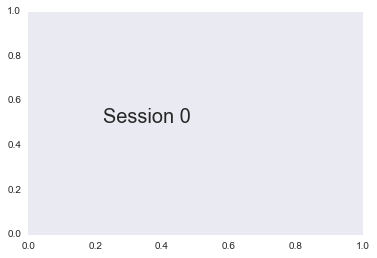

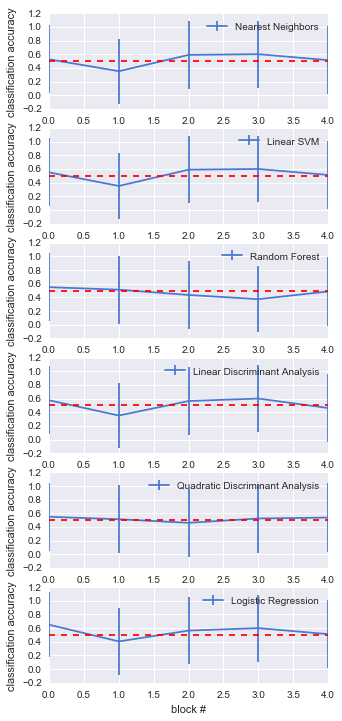

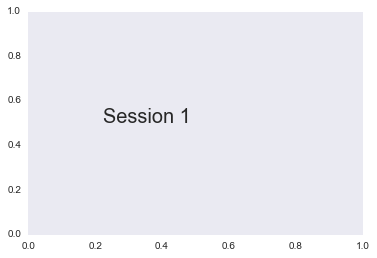

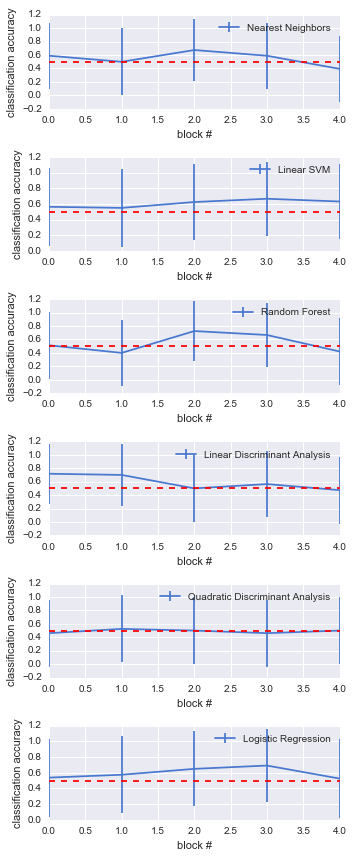

In [83]:
print accuracy.shape
for sessI in range(0, accuracy.shape[0]):
    sesh_accuracy = np.squeeze(accuracy[sessI,:,:,:])
    # plot text indicating new session
    plt.figure()
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    xmin, xmax = axes.get_xlim()
    plt.text((xmax-xmin)/4.5, (ymax-ymin)/2, r'Session %i'%(sessI), fontsize=20)
    plt.grid(False)
    
    fig = plt.figure(figsize=(5, 12))
    for class_idx, cla in enumerate(classifiers):
        class_accuracy = np.squeeze(accuracy[sessI,:,class_idx,:])

        # plot errorbars for each classifier on all blocks within this session
        plt.subplot(len(classifiers), 1, class_idx+1)
        plt.errorbar(range(0, accuracy.shape[1]), class_accuracy[:,0], yerr = class_accuracy[:,1], hold=True, label=names[class_idx])
        plt.xlabel('block #')
        plt.ylabel('classification accuracy')
        plt.axhline(0.5, color='red', linestyle='--')
        plt.legend()
#         print class_accuracy.shape
#         break # only plot for 1 classifier
#     print sesh_accuracy.shape
    
#     break # only do it for 1 session

plt.tight_layout()

In [39]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# load the iris datasets
dataset = datasets.load_iris()
# create a base classifier used to evaluate a subset of attributes
model = LogisticRegression()
# create the RFE model and select 3 attributes
rfe = RFE(model, 3)
rfe = rfe.fit(dataset.data, dataset.target)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[False  True  True  True]
[2 1 1 1]


In [41]:
# Feature Importance
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# load the iris datasets
dataset = datasets.load_iris()
# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(dataset.data, dataset.target)
# display the relative importance of each attribute
print(model.feature_importances_)

[ 0.10329852  0.08443241  0.31908967  0.4931794 ]


## Plotting Spectrograms

Electrode layout:

    r=[
    1,32;		% G		(left temporal grid)
    33,38;		% TT		(left temporal tip)
    39,42;		% OF		(left orbitofrontal)
    43,46;		% AST		(left anterior subtemporal)
    47,50;		% MST		(left middle subtemporal)
    51,54;		% PST		(left posterior subtemporal)
    55,60;		% IO		(left inferior occipital)
    61,66;		% MO		(left left middle occipital)
    67,72;		% SO		(left superior occipital)
    73,80;		% PP		(left posterior parietal)
    81,86;		% LP		(left lateral parietal)
    87,90;		% PPST		(left posterior posterior subtemporal)
    91,96;		% LF		(left lateral frontal)
    ];
    

In [300]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plotSpect(wordgroup, chans_we_want, session, blockone, blocktwo):
    fig = plt.figure(figsize=(len(wordgroup)*6, 3.5))
    
    for idx, pair in enumerate(wordgroup):
        # load in data
        first_wordpair_dir = firstblock_dir + '/' + pair[0]
        second_wordpair_dir = secondblock_dir + '/' + pair[1]

        # initialize np arrays for holding feature vectors for each event
        first_pair_features = []
        second_pair_features = []

        # load in channels
        first_channels = os.listdir(first_wordpair_dir)
        second_channels = os.listdir(second_wordpair_dir)
        
        first_spect = []
        second_spect = []
        # loop through channels
        for jdx, chans in enumerate(first_channels):
            if jdx in chans_we_want:
                first_chan_file = first_wordpair_dir + '/' + chans
                second_chan_file = second_wordpair_dir + '/' + chans

                # load in data
                data_first = scipy.io.loadmat(first_chan_file)
                data_first = data_first['data']
                data_second = scipy.io.loadmat(second_chan_file)
                data_second = data_second['data']

                ## 06: get the time point for probeword on
                first_timeZero = data_first['timeZero'][0][0][0]
                second_timeZero = data_second['timeZero'][0][0][0]

                ## 07: get the time point of vocalization
                first_vocalization = data_first['vocalization'][0][0][0]
                second_vocalization = data_second['vocalization'][0][0][0]

                ## Power Matrix
                first_matrix = data_first['powerMatZ'][0][0]
                second_matrix = data_second['powerMatZ'][0][0]
                
                first_spect.append(first_matrix)
                second_spect.append(second_matrix)

#                 break
        first_numevents = np.array(first_spect).shape[1]
        second_numevents = np.array(second_spect).shape[1]
        # average along events and channels
        
        first_spect = np.mean(np.array(first_spect),axis=(0,1))
        second_spect = np.mean(np.array(second_spect), axis=(0,1))
        spect = second_spect-first_spect
        
        ## For plotting spectrogram separately
#         fig =plt.figure(figsize=(12,4))
#         fig1= plt.subplot(1,2,1)
#         ax1 = plt.gca()
#         im1 = plt.imshow(first_spect, interpolation='none', cmap='jet', aspect='auto')
#         plt.yticks(np.arange(0,7,1), freq_labels)
#         plt.legend()
#         plt.axvline(first_timeZero, color='k')
#         plt.gca().invert_yaxis()
#         plt.title(session + pair[0] + '(' + str(first_numevents) +')')
#         vmin1, vmax1 = plt.gci().get_clim()
#         divider = make_axes_locatable(ax1)
#         cax = divider.append_axes("right", size="5%", pad=0.05)
#         plt.colorbar(im1, cax=cax)
        
#         fig2 = plt.subplot(1,2,2)
#         ax2 = plt.gca()
#         im2 = plt.imshow(second_spect, interpolation='none', cmap='jet', aspect='auto')
#         plt.yticks(np.arange(0,7,1), freq_labels)
#         plt.legend()
#         plt.axvline(first_timeZero, color='k')
#         plt.gca().invert_yaxis()
#         plt.title(session + pair[1] + '(' + str(second_numevents) +')')
#         vmin2, vmax2 = plt.gci().get_clim()
#         divider = make_axes_locatable(ax2)
#         cax = divider.append_axes("right", size="5%", pad=0.05)
#         plt.colorbar(im2, cax=cax)

#         ## set to compare spectrograms fairly
#         im1.set_clim([-0.2, 0.15])
#         im2.set_clim([-0.2, 0.15])
#         im1.set_clim([min(vmin1,vmin2), max(vmax1,vmax2)])
#         im2.set_clim([min(vmin1,vmin2), max(vmax1,vmax2)])
        
        
        ## Create spectrogram     
        ## Plotting Paired Distances
        plt.subplot(1, len(wordgroup), idx+1)
#         fig =plt.figure(figsize=(10, 20))
        ax = plt.gca()
        im = plt.imshow(spect, interpolation='nearest', cmap='jet', aspect='auto')
        plt.yticks(np.arange(0,7,1), freq_labels)
        plt.legend()
        plt.axvline(first_timeZero, color='k')
        plt.gca().invert_yaxis()
        plt.title(session + ' comparing ' + pair[0] + '(' + str(first_numevents) +') vs '+ pair[1] + '(' + str(second_numevents) +')')
        vmin, vmax = plt.gci().get_clim()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        im.set_clim([-0.2, 0.2])
        
        yline = np.arange(1,7,1)
        for i in range(0, len(yline)):
            plt.axvline(x=yline[i], color='k')
        ax.grid(False)
        
        
        
    plt.tight_layout()
#         break

In [303]:
##### HYPER-PARAMETERS TO TUNE
anova_threshold = 90   # how many channels we want to keep
distances = Distance.cosine # define distance metric to use
num_time_windows = 5
freq_bands = np.arange(0,7,1)

channels_we_want = np.arange(43,54,1)
# channels_we_want = np.arange(0,96,1)
print len(channels_we_want)

freq_labels = ['delta', 'theta', 'alpha', 'beta', 'low gamma', 'high gamma', 'HFO']
print freq_bands
print [freq_labels[i] for i in freq_bands]

print "The length of the feature vector for each channel will be: ", num_time_windows*len(freq_bands)

11
[0 1 2 3 4 5 6]
['delta', 'theta', 'alpha', 'beta', 'low gamma', 'high gamma', 'HFO']
The length of the feature vector for each channel will be:  35


Analyzing session  session_1
Analyzing block  BLOCK_0  and  BLOCK_1
['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_JUICE', 'JUICE_GLASS']
['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_PANTS', 'PANTS_GLASS']
[['BRICK_CLOCK', 'BRICK_CLOCK'], ['CLOCK_BRICK', 'CLOCK_BRICK']]
[['BRICK_CLOCK', 'CLOCK_BRICK']]
[['GLASS_JUICE', 'GLASS_PANTS']]
[['JUICE_GLASS', 'PANTS_GLASS']]
[['BRICK_CLOCK', 'GLASS_PANTS'], ['BRICK_CLOCK', 'PANTS_GLASS']]
Analyzing block  BLOCK_1  and  BLOCK_2
['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_PANTS', 'PANTS_GLASS']
['BRICK_JUICE', 'GLASS_PANTS', 'JUICE_BRICK', 'PANTS_GLASS']
[['GLASS_PANTS', 'GLASS_PANTS'], ['PANTS_GLASS', 'PANTS_GLASS']]
[['GLASS_PANTS', 'PANTS_GLASS']]
[['BRICK_CLOCK', 'BRICK_JUICE']]
[['CLOCK_BRICK', 'JUICE_BRICK']]
[['BRICK_CLOCK', 'GLASS_PANTS'], ['BRICK_CLOCK', 'PANTS_GLASS']]
Analyzing block  BLOCK_2  and  BLOCK_3
['BRICK_JUICE', 'GLASS_PANTS', 'JUICE_BRICK', 'PANTS_GLASS']
['BRICK_JUICE', 'CLOCK_GLASS', 'GLASS_CLOCK', 'JUICE_BRICK']
[['BRICK_JUICE', 'BRICK_JUICE'

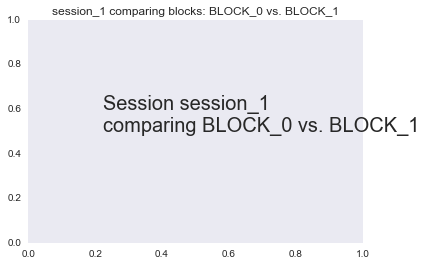

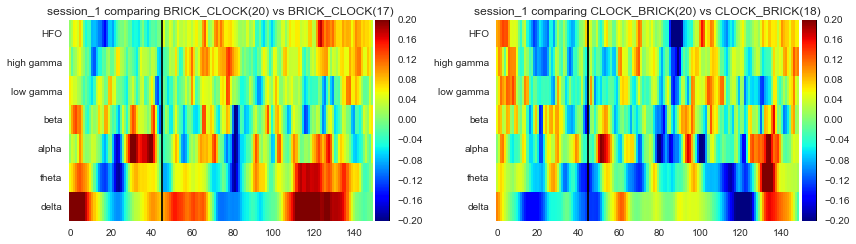

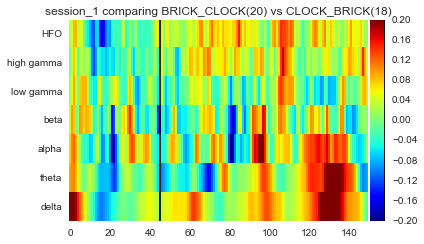

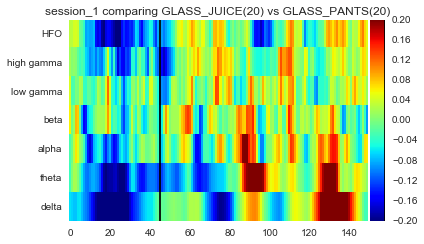

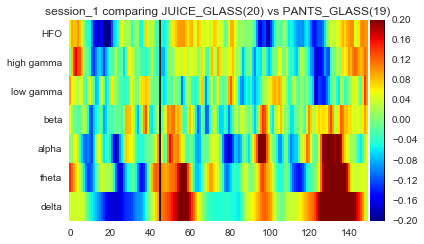

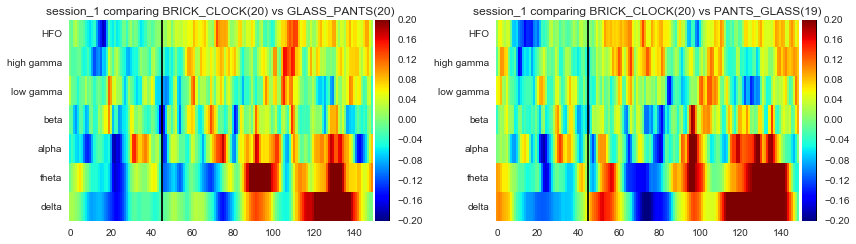

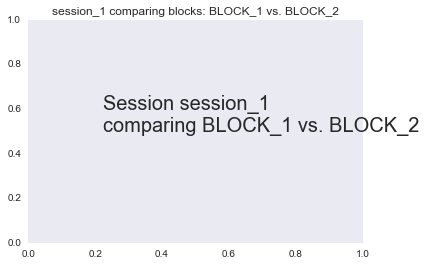

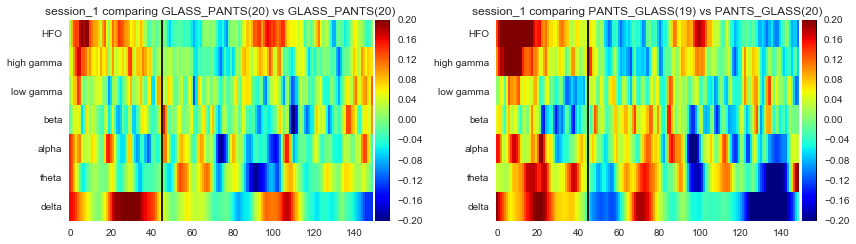

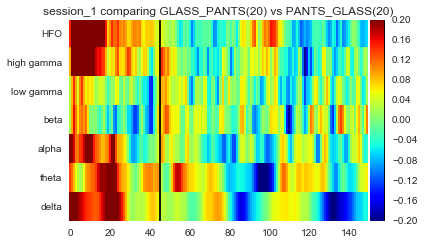

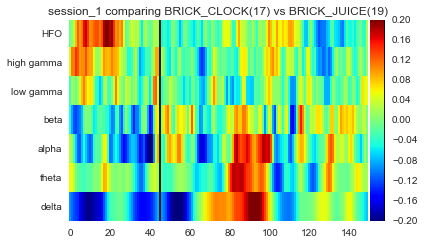

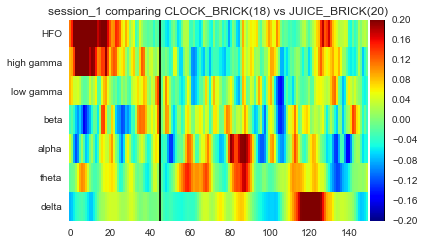

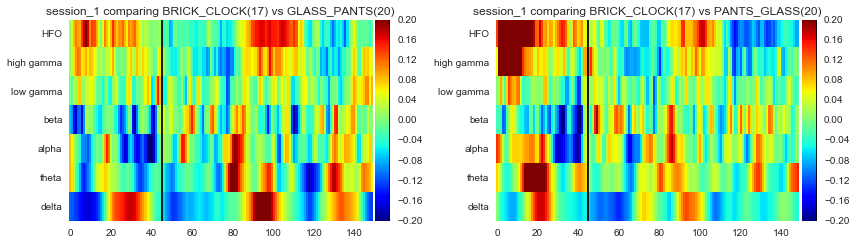

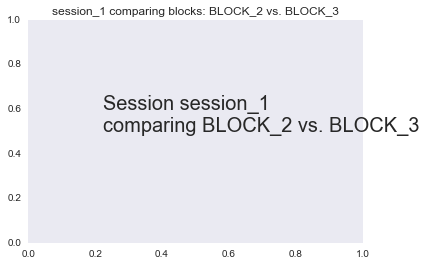

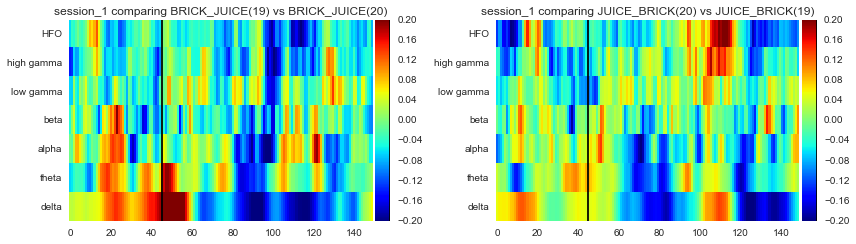

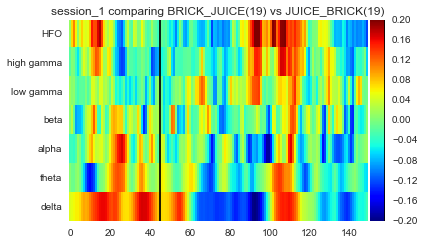

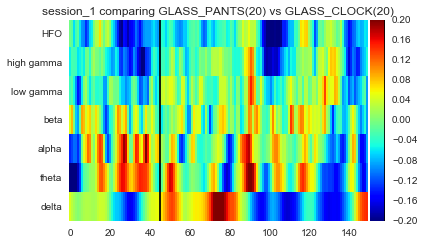

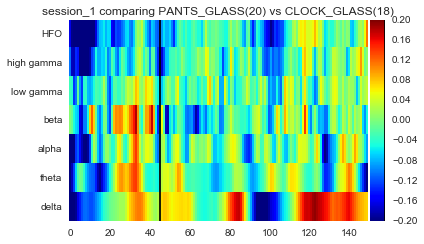

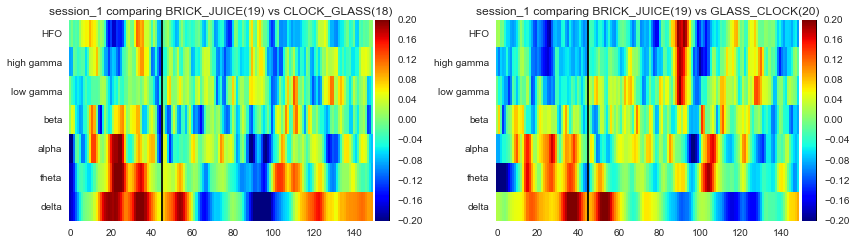

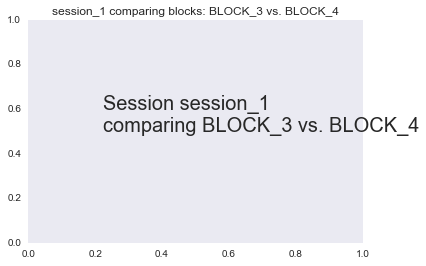

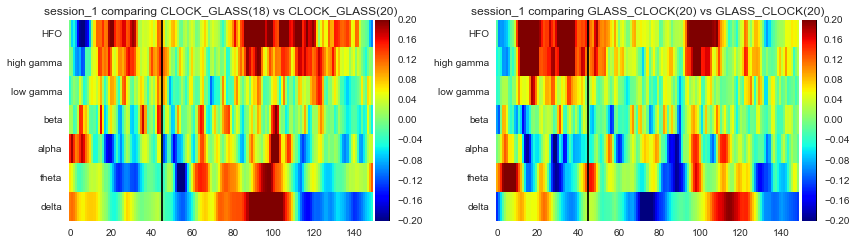

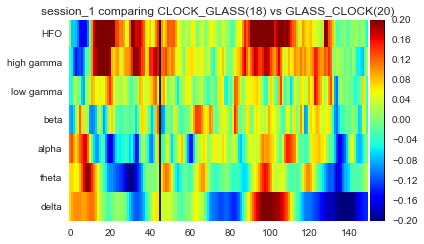

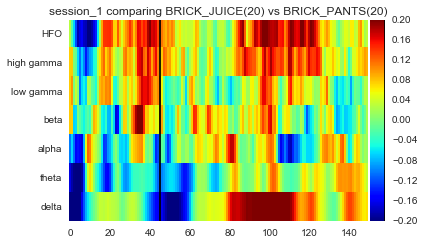

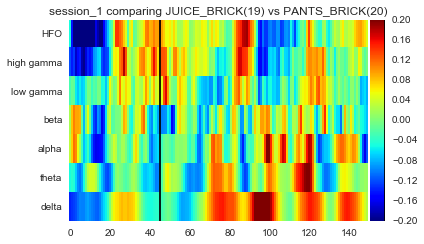

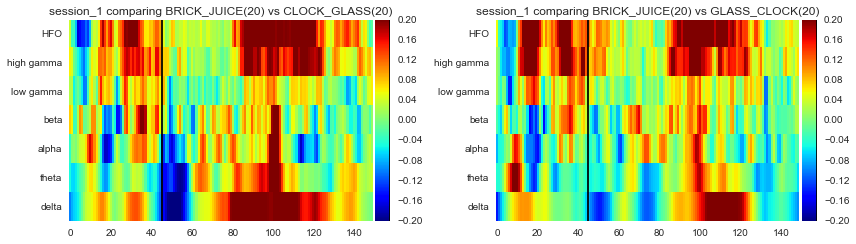

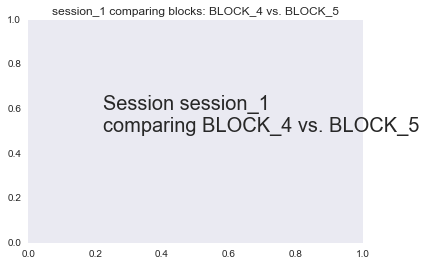

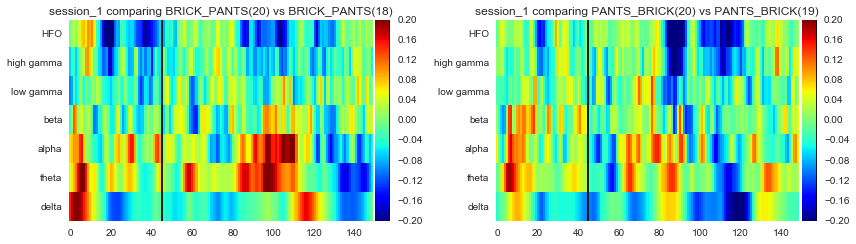

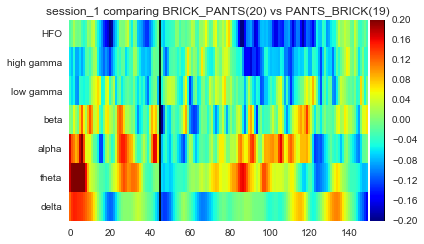

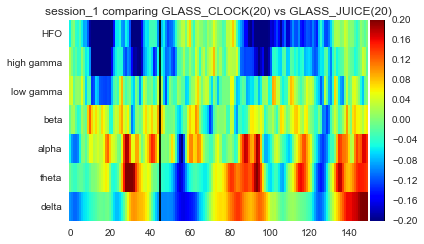

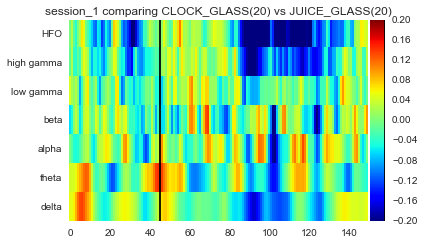

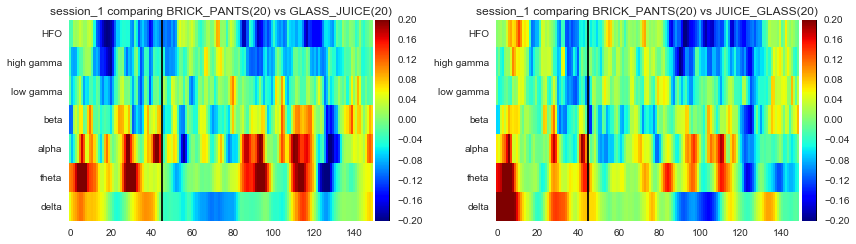

In [304]:
######## Get list of files (.mat) we want to work with ########
filedir = '../condensed_data/blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:]

# loop through each session
for session in sessions:
    print "Analyzing session ", session
    sessiondir = filedir + session
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)
    
    if len(blocks) != 6: # error check on the directories
        print blocks
        print("Error in the # of blocks. There should be 5.")
        break
    
    # loop through each block one at a time, analyze
    for i in range(0, 5):
        print "Analyzing block ", blocks[i], ' and ', blocks[i+1]
        firstblock = blocks[i]
        secondblock = blocks[i+1]
        
        firstblock_dir = sessiondir+'/'+firstblock
        secondblock_dir = sessiondir+'/'+secondblock
        # in each block, get list of word pairs from first and second block
        first_wordpairs = os.listdir(sessiondir+'/'+firstblock)
        second_wordpairs = os.listdir(sessiondir+'/'+secondblock)
        
        diff_word_group = []
        reverse_word_group = []
        probe_word_group = []
        target_word_group = []
        same_word_group = []
        
        print first_wordpairs
        print second_wordpairs
        
        #### plot meta information about which session and blocks we're analyzing
        fig=plt.figure()
        axes = plt.gca()
        ymin, ymax = axes.get_ylim()
        xmin, xmax = axes.get_xlim()
        plt.text((xmax-xmin)/4.5, (ymax-ymin)/2, r'Session %s %scomparing %s vs. %s'%(session, '\n',firstblock, secondblock), fontsize=20)
        plt.title(session + ' comparing blocks: ' + firstblock + ' vs. ' + secondblock)
        plt.grid(False)
        
        # go through first block and assign pairs to different groups
        for idx, pair in enumerate(first_wordpairs):
#             print "Analyzing ", pair
            # obtain indices of: sameword, reverseword, differentwords, probeoverlap, targetoverlap
            same_word_index = find_same(pair, second_wordpairs)
            reverse_word_index = find_reverse(pair, second_wordpairs)
            diff_word_index = find_different(pair, second_wordpairs)
            probe_word_index = find_probe(pair, second_wordpairs)
            target_word_index = find_target(pair, second_wordpairs)
            
            # append to list groupings holding pairs of these word groupings
            if same_word_index != -1 and not inGroup(same_word_group, [pair, second_wordpairs[same_word_index]]):
                same_word_group.append([pair, second_wordpairs[same_word_index]])
            if reverse_word_index != -1 and not inGroup(reverse_word_group, [pair, second_wordpairs[reverse_word_index]]): 
                reverse_word_group.append([pair, second_wordpairs[reverse_word_index]])
            if diff_word_index != -1:
                if isinstance(diff_word_index, list): # if list, break it down and one pairing at a time
                    for diffI in diff_word_index:     # loop through each different word index
                        if not inGroup(diff_word_group, [pair, second_wordpairs[diffI]]):
                            diff_word_group.append([pair, second_wordpairs[diffI]])
                else:
                    diff_word_group.append([pair, second_wordpairs[diff_word_index]])
            if probe_word_index != -1 and not inGroup(probe_word_group, [pair, second_wordpairs[probe_word_index]]): 
                probe_word_group.append([pair, second_wordpairs[probe_word_index]])
            if target_word_index != -1 and not inGroup(target_word_group, [pair, second_wordpairs[target_word_index]]):
                target_word_group.append([pair, second_wordpairs[target_word_index]])
        # end of loop through word pairs
    # end of loop through block
        print same_word_group
        print reverse_word_group
        print probe_word_group
        print target_word_group
        print diff_word_group[0:2]
        
        #### Go through each group and extract the feature data per event
        ## 01: Same Word Group
        plotSpect(same_word_group, channels_we_want, session, firstblock, secondblock)
        plotSpect(reverse_word_group, channels_we_want, session, firstblock, secondblock)
        plotSpect(probe_word_group,channels_we_want, session, firstblock, secondblock)
        plotSpect(target_word_group,channels_we_want, session, firstblock, secondblock)
        plotSpect(diff_word_group[0:2],channels_we_want, session, firstblock, secondblock)
    break